In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [3]:
def get_data_event(event_name, data):
    
    df = data[['user_id', 'event_data']].loc[data['event_name']==event_name]
    
    if event_name == 'levelEnd':
        regex_sub = re.compile(r'\[([",A-Za-z]+|'')\]')
        for i in range(df.shape[0]):
            df['event_data'].iloc[i] = re.sub(regex_sub, '"NoData"', # нужно поправить
                                              df['event_data'].iloc[i])        
    
    # спличу данные на отдельные столбцы
    split_data = df['event_data'].str.split(pat=',')
    
    if event_name == 'levelEnd':
        split_data = list(map(lambda x: x[:5]+x[6:] if len(x) == 19 else x, 
                              split_data))
        split_data = pd.DataFrame(split_data, index=df.index)
        
    elif event_name == 'levelStart':
        split_data = list(map(lambda x: x[:4]+x[5:] if len(x) == 12 else x, 
                              split_data))
        split_data = pd.DataFrame(split_data, index=df.index)

    # регулярка для поиска названия столбцов
    regex_col_names = re.compile(r'"([a-zA-z0-9]+)":', 
                                 re.UNICODE) 
    
    # записываю названия будущих столбцов
    column_names = list(map(lambda x: regex_col_names.findall(x)[0], 
                        split_data.iloc[0])) 
    
    # добавляю к названиям имя ивента
    column_names = list(map(lambda x: '_'.join([x, event]), 
                            column_names))
    
    # регулярка для поиска значений столбцов
    regex_col_values = re.compile(r':"*([-A-Za-z0-9_]+|'')') 
    
    # получаю значения колонок и записываю их в массив
    game_status_data = pd.DataFrame(index=df.index, columns=column_names)
    for i in game_status_data.index:
        game_status_data.loc[i] = list(map(lambda x: regex_col_values.findall(x)[0], split_data.loc[i]))

    df = df.drop('event_data', axis=1)
    df = df.merge(game_status_data, how='left', left_index=True, right_index=True)
    
    return df

---

In [4]:
data = pd.read_csv(r'C:\Users\home\Desktop\analysis\data.csv')

In [5]:
data.head()

,user_id,media_source,client_time,session_index,game_status,event_name,event_data
0,60c588d7b4d1b24b40531f29,organic,2021-06-05 07:23:06,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""Xiaomi POCO M2 Pro"",""graphicMemory""..."
1,60d34c7ab4d1b24b405324ac,organic,2021-06-05 16:33:26,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-J200G"",""graphicMemory"":2..."
2,60babef87c80da6a9442cb86,ad-traffic,2021-06-05 00:02:07,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-G781B"",""graphicMemory"":2..."
3,60bac0e912667e6a8d107731,ad-traffic,2021-06-05 00:04:29,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-T290"",""graphicMemory"":51..."
4,60babfb17c80da6a9442cb87,organic,2021-06-05 00:05:16,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-N960F"",""graphicMemory"":2..."


In [6]:
data.tail()

,user_id,media_source,client_time,session_index,game_status,event_name,event_data
396094,60bb2f3912667e6a8d107757,organic,2021-06-12 11:52:41,54,"{""coins"":1174190,""freeRounds"":30,""freeUndo"":30...",transactionComplete,"{""inLevel"":false,""usdProceed"":68.1768094378241..."
396095,60bb2f3912667e6a8d107757,organic,2021-06-12 15:18:06,57,"{""coins"":7885,""freeRounds"":0,""freeUndo"":394,""f...",transactionComplete,"{""inLevel"":false,""usdProceed"":6.81001009386441..."
396096,60bb2f3912667e6a8d107757,organic,2021-06-12 15:18:30,57,"{""coins"":107885,""freeRounds"":0,""freeUndo"":394,...",transactionComplete,"{""inLevel"":false,""usdProceed"":13.6285433543043..."
396097,60bc090c12667e6a8d1077b8,organic,2021-06-12 22:48:26,2,"{""coins"":45274,""freeRounds"":0,""freeUndo"":3,""fr...",transactionComplete,"{""inLevel"":false,""usdProceed"":1.393,""productDe..."
396098,60bbf4a373c31e6a292b7ad1,ad-traffic,2021-06-12 23:27:05,99,"{""coins"":8789,""freeRounds"":0,""freeUndo"":0,""fre...",transactionComplete,"{""inLevel"":true,""usdProceed"":1.391999345326586..."


---

## Prepare data for analysis 

### Column game_status	

In [7]:
game_st = data[['user_id', 'game_status']]

In [8]:
game_status_split = game_st['game_status'].str.split(pat=',') #спличу данные на отдельные столбцы

In [9]:
col_game_st = list(map(lambda x: re.sub('[^A-Za-z]', '', x),      # получаю названия будущих столбцов.
                       game_status_split[0][:9]))                 # пришлось обрезать кол-во столбцов
                                                                  # т.к в некоторых строках нет последних
                                                                  # 3-x столбцов

In [10]:
col_game_st = list(map(lambda x: '_'.join([x, 'game_status']), col_game_st))

In [11]:
game_status_data = np.empty((game_st.shape[0], len(col_game_st)), dtype=int)
for i in range(game_st.shape[0]):
    game_status_data[i] = list(map(lambda x: re.sub('[^0-9]', '', x), game_status_split[i][:9]))
    
# получаю значения колонок и записываю их в массив

In [12]:
game_status_data = pd.DataFrame(game_status_data, columns=col_game_st) # преобразую массив в DF

In [13]:
game_st = game_st.drop('game_status', axis=1)

In [14]:
game_status_data = game_st.merge(game_status_data, left_index=True, right_index=True) # объяединяю два DF

In [15]:
game_status_data.head()

,user_id,coins_game_status,freeRounds_game_status,freeUndo_game_status,freeWildCard_game_status,freeAddCards_game_status,level_game_status,map_game_status,bet_game_status,gladeId_game_status
0,60c588d7b4d1b24b40531f29,0,0,0,0,0,0,1,1,1
1,60d34c7ab4d1b24b405324ac,0,0,0,0,0,0,1,1,1
2,60babef87c80da6a9442cb86,0,0,0,0,0,0,1,1,1
3,60bac0e912667e6a8d107731,0,0,0,0,0,0,1,1,1
4,60babfb17c80da6a9442cb87,0,0,0,0,0,0,1,1,1


### Column event_data

#### Event appInstall

In [16]:
event = 'appInstall'

In [17]:
appInstall_data = get_data_event(event, data)

In [18]:
appInstall_data.head()

,user_id,device_appInstall,graphicMemory_appInstall,systemMemory_appInstall
0,60c588d7b4d1b24b40531f29,Xiaomi,2048,5582
1,60d34c7ab4d1b24b405324ac,samsung,256,892
2,60babef87c80da6a9442cb86,samsung,2048,5562
3,60bac0e912667e6a8d107731,samsung,512,1847
4,60babfb17c80da6a9442cb87,samsung,2048,5616


#### Event learning

In [19]:
event = 'learning'

In [20]:
learning_data = get_data_event(event, data)

In [21]:
learning_data.head()

,user_id,name_learning,level_learning
813,60bb736b12667e6a8d107774,CRUISE_USE_BOOSTERS_MORE,82
814,60bba5ea7c80da6a9442cbf3,CRUISE_USE_BOOSTERS_MORE,192
815,60bb736b12667e6a8d107774,CRUISE_USE_BOOSTERS_MORE,82
816,60bb736b12667e6a8d107774,CRUISE_USE_BOOSTERS_MORE,82
817,60bba5ea7c80da6a9442cbf3,CRUISE_USE_BOOSTERS_MORE,194


#### Event getCoins

In [22]:
event = 'getCoins'

In [23]:
get_coins_data = get_data_event(event, data)

In [24]:
get_coins_data.head()

,user_id,amount_getCoins,from_getCoins
451,60baf7b612667e6a8d107740,1200,LevelBonus
452,60bba6a74770af6a2faa05c4,-1000,LevelStart
453,60baefee4770af6a2faa0565,-2000,LevelStart
454,60bad8307c80da6a9442cb91,2308,LevelBonus
455,60baf2267c80da6a9442cb98,5966,LevelBonus


#### Event gladeComplete

In [25]:
event = 'gladeComplete'

In [26]:
gladeComplete_data = get_data_event(event, data)

In [89]:
gladeComplete_data.head()

,user_id,levels_gladeComplete
200998,60bb1bac12667e6a8d10774e,63
200999,60bb1bac12667e6a8d10774e,39
201000,60bb66084770af6a2faa05a0,10
201001,60bb7de34770af6a2faa05ab,6
201002,60bb46a573c31e6a292b7a79,41


#### Event getBooster

In [28]:
event = 'getBooster'

In [29]:
getBooster_data = get_data_event(event, data)

In [30]:
getBooster_data.head()

,user_id,type_getBooster,from_getBooster,amount_getBooster
2348,60c588d7b4d1b24b40531f29,freeUndo,FirstGift,5
2349,60c588d7b4d1b24b40531f29,freeExtraCards,FirstGift,5
2350,60c588d7b4d1b24b40531f29,freeWildCard,FirstGift,5
2351,60c588d7b4d1b24b40531f29,freeLevels,DailyBonus,3
2352,60c588d7b4d1b24b40531f29,freeLevels,UseInGame,-1


#### Event levelEnd

In [31]:
event = 'levelEnd'

In [32]:
levelEnd_data = get_data_event(event, data)

In [33]:
levelEnd_data = levelEnd_data.drop('streaksRewards_levelEnd', axis=1)

In [34]:
levelEnd_data.head()

,user_id,time_levelEnd,fromMenu_levelEnd,level_levelEnd,levelLoop_levelEnd,gameType_levelEnd,win_levelEnd,collectedCoins_levelEnd,bonusCoins_levelEnd,stars_levelEnd,cardsOnField_levelEnd,cardsOnHands_levelEnd,baseLuckyIndex_levelEnd,targetGoldIndex_levelEnd,totalLuckyIndex_levelEnd,cardsRemainsBonus_levelEnd,prediction_levelEnd,predictionCameTrue_levelEnd
39849,60babef87c80da6a9442cb86,32549,false,1,1,0,VICTORY,3088,0,5,0,17,0,0,0,1580,Default,false
39850,60babef87c80da6a9442cb86,45005,false,2,6,0,VICTORY,1214,0,3,0,3,0,0,0,90,VictoryWith1Or2Cards,true
39851,60babef87c80da6a9442cb86,49074,false,3,7,0,VICTORY_WITH_BOOSTER,1245,0,2,0,5,0,0,0,150,VictoryWith4OrMoreCards,true
39852,60bac0e912667e6a8d107731,29419,false,1,1,0,VICTORY,3158,0,5,0,17,0,0,0,1620,Default,false
39853,60babfb17c80da6a9442cb87,31960,false,1,1,0,VICTORY,3128,0,5,0,17,0,0,0,1660,Default,false


#### Event getStarsCruise

In [35]:
event = 'getStarsCruise'

In [36]:
getStarsCruise_data = get_data_event(event, data)

In [37]:
getStarsCruise_data.head()

,user_id,amount_getStarsCruise
169548,60bad8307c80da6a9442cb91,2
169549,60bad8307c80da6a9442cb91,1
169550,60bad8307c80da6a9442cb91,2
169551,60bad8307c80da6a9442cb91,2
169986,60bb1bac12667e6a8d10774e,2


#### Event levelStart

In [38]:
event = 'levelStart'

In [39]:
levelStart_data = get_data_event(event, data)

In [40]:
levelStart_data.head()

,user_id,retry_levelStart,level_levelStart,levelLoop_levelStart,gameType_levelStart,price_levelStart,cardsInHand_levelStart,baseLuckyIndex_levelStart,targetGoldIndex_levelStart,targetCoins_levelStart,totalLuckyIndex_levelStart,prediction_levelStart
294447,60c588d7b4d1b24b40531f29,false,67,0,0,2000,17,-3,-3,3350,-3,DefeatWith1Or2Cards
294448,60c588d7b4d1b24b40531f29,false,68,0,0,2000,14,-3,-3,2650,-3,DefeatWith1Or2Cards
294449,60c588d7b4d1b24b40531f29,false,69,0,0,2000,13,0,0,1950,0,DefeatWith1Or2Cards
294450,60c588d7b4d1b24b40531f29,false,70,0,0,2000,12,0,0,1250,0,DefeatWith1Or2Cards
294451,60c588d7b4d1b24b40531f29,false,71,0,0,2000,15,-3,-3,550,-3,DefeatWith1Or2Cards


#### Event transactionComplete

In [41]:
event = 'transactionComplete'

In [42]:
transactionComplete_data = get_data_event(event, data)

In [43]:
transactionComplete_data.head()

,user_id,inLevel_transactionComplete,usdProceed_transactionComplete,productDescription_transactionComplete
396062,60bb7b6e4770af6a2faa05a7,false,5,Fun
396063,60bb1a304770af6a2faa0575,false,1,Starter
396064,60bb1a304770af6a2faa0575,false,1,Gold
396065,60bba5ea7c80da6a9442cbf3,false,5,Fun
396066,60bae7544770af6a2faa0563,false,5,Fun


---

## Point 1.1

#### Используя предоставленный датасет, изучите воронку обучения и в целом вступление в игру. Сформулируйте гипотезы о том, что можно улучшить, подкрепите их данными. Обучение можно считать пройденным, когда пройдена первая грядка.

In [44]:
drop = ['game_status', 'event_data']
data_ch = data.drop(drop, axis=1)

In [45]:
data_ch = data_ch.merge(appInstall_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [46]:
data_ch = data_ch.merge(learning_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [47]:
data_ch = data_ch.merge(get_coins_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [88]:
data_ch = data_ch.drop('levels_gladeComplete' ,axis=1)

In [90]:
data_ch = data_ch.merge(gladeComplete_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [49]:
data_ch = data_ch.merge(getBooster_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [50]:
data_ch = data_ch.merge(levelEnd_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [51]:
data_ch = data_ch.merge(getStarsCruise_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [52]:
data_ch = data_ch.merge(levelStart_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [53]:
data_ch = data_ch.merge(transactionComplete_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [54]:
data_ch = data_ch.merge(game_status_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [55]:
data_ch.head()

,user_id,media_source,client_time,session_index,event_name,device_appInstall,graphicMemory_appInstall,systemMemory_appInstall,name_learning,level_learning,...,productDescription_transactionComplete,coins_game_status,freeRounds_game_status,freeUndo_game_status,freeWildCard_game_status,freeAddCards_game_status,level_game_status,map_game_status,bet_game_status,gladeId_game_status
0,60c588d7b4d1b24b40531f29,organic,2021-06-05 07:23:06,1,appInstall,Xiaomi,2048,5582,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1
1,60d34c7ab4d1b24b405324ac,organic,2021-06-05 16:33:26,1,appInstall,samsung,256,892,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1
2,60babef87c80da6a9442cb86,ad-traffic,2021-06-05 00:02:07,1,appInstall,samsung,2048,5562,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1
3,60bac0e912667e6a8d107731,ad-traffic,2021-06-05 00:04:29,1,appInstall,samsung,512,1847,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1
4,60babfb17c80da6a9442cb87,organic,2021-06-05 00:05:16,1,appInstall,samsung,2048,5616,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1


---

In [288]:
data_ch_grouped_1 = data_ch[data_ch['session_index'] == 1].groupby('user_id').agg(['count', 'mean'])

In [289]:
converse = pd.DataFrame(index=['Количество уникальных пользователей', 
                               'Среднее количество событий'])
for i in np.sort(data_ch['session_index'].unique()):
    dt = data_ch[data_ch['session_index'] == i].groupby('user_id').count()
    converse[i] = [dt['session_index'].shape[0],
                   dt['session_index'].quantile(0.5)]

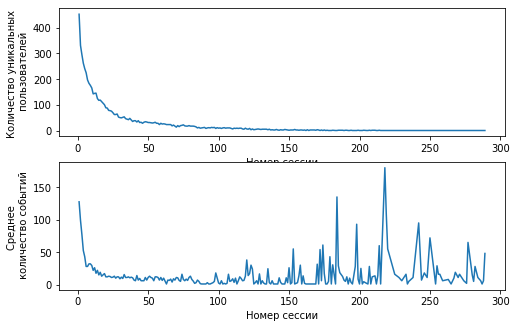

In [290]:
gridsize = (3, 2)
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)

ax1.plot(converse.columns, converse.loc['Количество уникальных пользователей'])
ax1.set_ylabel('Количество уникальных \n пользователей')
ax1.set_xlabel('Номер сессии')

ax2.plot(converse.columns, converse.loc['Среднее количество событий'])
ax2.set_ylabel('Среднее \n количество событий')
ax2.set_xlabel('Номер сессии')

plt.show()

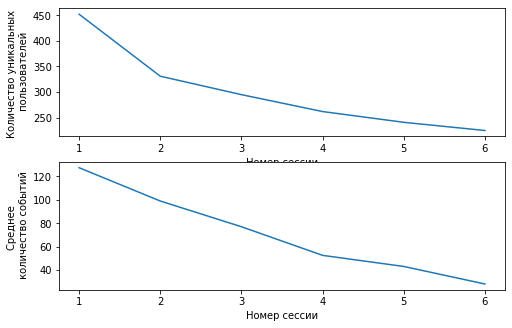

In [321]:
gridsize = (3, 2)
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)

ax1.plot(converse.columns[:6], converse.loc['Количество уникальных пользователей'][:6])
ax1.set_ylabel('Количество уникальных \n пользователей')
ax1.set_xlabel('Номер сессии')

ax2.plot(converse.columns[:6], converse.loc['Среднее количество событий'][:6])
ax2.set_ylabel('Среднее \n количество событий')
ax2.set_xlabel('Номер сессии')

plt.show()

 ---

In [311]:
converse1 = pd.DataFrame(index=['Количество уникальных пользователей', 
                               'Среднее количество событий'])
for i in np.sort(data_ch['session_index'].unique()):
    dt = data_ch[data_ch['session_index'] == i].groupby('user_id').count()
    dt = dt[dt['session_index'] != 1]
    converse1[i] = [dt['session_index'].shape[0],
                   dt['session_index'].quantile(0.5)]

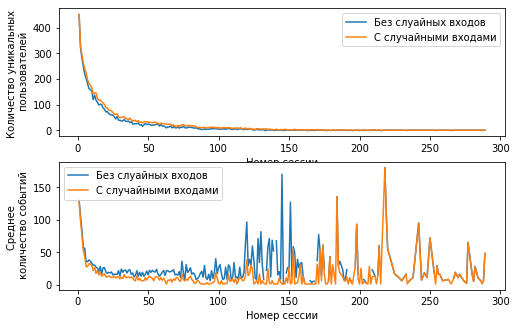

In [320]:
gridsize = (3, 2)
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)

ax1.plot(converse1.columns, converse1.loc['Количество уникальных пользователей'])
ax1.plot(converse.columns, converse.loc['Количество уникальных пользователей'])
ax1.set_ylabel('Количество уникальных \n пользователей')
ax1.set_xlabel('Номер сессии')
ax1.legend(['Без слуайных входов', 'С случайными входами'])

ax2.plot(converse1.columns, converse1.loc['Среднее количество событий'])
ax2.plot(converse.columns, converse.loc['Среднее количество событий'])
ax2.set_ylabel('Среднее \n количество событий')
ax2.set_xlabel('Номер сессии')
ax2.legend(['Без слуайных входов', 'С случайными входами'])
plt.savefig(r'C:\Users\home\Desktop\analysis\5.png')

plt.show()

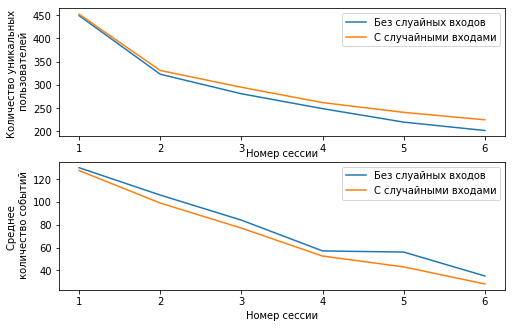

In [319]:
gridsize = (3, 2)
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)

ax1.plot(converse1.columns[:6], converse1.loc['Количество уникальных пользователей'][:6])
ax1.plot(converse.columns[:6], converse.loc['Количество уникальных пользователей'][:6])
ax1.set_ylabel('Количество уникальных \n пользователей')
ax1.set_xlabel('Номер сессии', labelpad=-5)
ax1.legend(['Без слуайных входов', 'С случайными входами'])

ax2.plot(converse1.columns[:6], converse1.loc['Среднее количество событий'][:6])
ax2.plot(converse.columns[:6], converse.loc['Среднее количество событий'][:6])
ax2.set_ylabel('Среднее \n количество событий')
ax2.set_xlabel('Номер сессии')
ax2.legend(['Без слуайных входов', 'С случайными входами'])

plt.savefig(r'C:\Users\home\Desktop\analysis\4.png')
plt.show()

---

In [327]:
data_full = data_ch.copy()

In [332]:
dummie = ['media_source', 'event_name', 'device_appInstall', 
          'inLevel_transactionComplete', 'productDescription_transactionComplete',
         'prediction_levelStart', 'retry_levelStart', 'fromMenu_levelEnd',
         'win_levelEnd', 'prediction_levelEnd', 'predictionCameTrue_levelEnd',
         'type_getBooster', 'from_getBooster', 'from_getCoins',
         'name_learning']

In [335]:
for i in dummie:
    data_full = data_full.merge(pd.get_dummies(data_full[i], prefix=i), 
                               how='left', 
                               left_index=True, 
                               right_index=True)
    data_full = data_full.drop(i, axis=1)

In [340]:
data_full.head()

,user_id,client_time,session_index,graphicMemory_appInstall,systemMemory_appInstall,level_learning,amount_getCoins,amount_getBooster,time_levelEnd,level_levelEnd,...,name_learning_SLOTS_SPOTLIGHT_ON_BET_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_CURRENCY_COUNTER,name_learning_SLOTS_SPOTLIGHT_ON_LEADERBOARD,name_learning_SLOTS_SPOTLIGHT_ON_SPIN_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_WIDGET,name_learning_SLOTS_TUTORIAL_REWARD,name_learning_STREAK_INFO,name_learning_UNLIMITED_TIP_OF_USING_AVAILABLE_WILD_CARD,name_learning_USE_UNDO,name_learning_USE_WILD_CARD
0,60c588d7b4d1b24b40531f29,2021-06-05 07:23:06,1,2048,5582,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,60d34c7ab4d1b24b405324ac,2021-06-05 16:33:26,1,256,892,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,60babef87c80da6a9442cb86,2021-06-05 00:02:07,1,2048,5562,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,60bac0e912667e6a8d107731,2021-06-05 00:04:29,1,512,1847,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,60babfb17c80da6a9442cb87,2021-06-05 00:05:16,1,2048,5616,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


---

In [427]:
data_full_1 = data_full.loc[data_full['session_index'] == 1]

In [428]:
data_full_count_1 = data_full_1.groupby(['user_id']).sum()

In [429]:
data_full_count_1.head()

,session_index,coins_game_status,freeRounds_game_status,freeUndo_game_status,freeWildCard_game_status,freeAddCards_game_status,level_game_status,map_game_status,bet_game_status,gladeId_game_status,...,name_learning_SLOTS_SPOTLIGHT_ON_BET_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_CURRENCY_COUNTER,name_learning_SLOTS_SPOTLIGHT_ON_LEADERBOARD,name_learning_SLOTS_SPOTLIGHT_ON_SPIN_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_WIDGET,name_learning_SLOTS_TUTORIAL_REWARD,name_learning_STREAK_INFO,name_learning_UNLIMITED_TIP_OF_USING_AVAILABLE_WILD_CARD,name_learning_USE_UNDO,name_learning_USE_WILD_CARD
user_id,,,,,,,,,,,,,,,,,,,,,
605717849c72f901462a2019,1,0,0,0,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60ba837f4770af6a2faa0544,249,5699949,15,510,785,272,6460,249,390,444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60ba999a73c31e6a292b7a2b,29,498934,0,140,130,135,37,29,29,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60babef87c80da6a9442cb86,43,403561,20,126,105,131,206,43,43,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60babfb17c80da6a9442cb87,14,58656,0,39,33,36,10,14,14,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [430]:
data_full_count_1['coins_game_status'] = data_full_count_1['coins_game_status'] / data_full_count_1['session_index']

In [431]:
data_full_count_1['coins_game_status'] = data_full_count_1['coins_game_status'].astype(int)

In [432]:
data_full_count_1 = data_full_count_1.drop('session_index', axis = 1)

In [443]:
data_full_count_1 = data_full_count_1.dropna(axis=1, how='all')

In [446]:
data_full_count_1.head()

,coins_game_status,freeRounds_game_status,freeUndo_game_status,freeWildCard_game_status,freeAddCards_game_status,level_game_status,map_game_status,bet_game_status,gladeId_game_status,media_source_ad-traffic,...,name_learning_SLOTS_SPOTLIGHT_ON_BET_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_CURRENCY_COUNTER,name_learning_SLOTS_SPOTLIGHT_ON_LEADERBOARD,name_learning_SLOTS_SPOTLIGHT_ON_SPIN_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_WIDGET,name_learning_SLOTS_TUTORIAL_REWARD,name_learning_STREAK_INFO,name_learning_UNLIMITED_TIP_OF_USING_AVAILABLE_WILD_CARD,name_learning_USE_UNDO,name_learning_USE_WILD_CARD
user_id,,,,,,,,,,,,,,,,,,,,,
605717849c72f901462a2019,0,0,0,0,0,0,1,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60ba837f4770af6a2faa0544,22891,15,510,785,272,6460,249,390,444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60ba999a73c31e6a292b7a2b,17204,0,140,130,135,37,29,29,29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60babef87c80da6a9442cb86,9385,20,126,105,131,206,43,43,43,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60babfb17c80da6a9442cb87,4189,0,39,33,36,10,14,14,14,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
